In [57]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from config import get_password

# retrieve password
password = get_password()

In [58]:
q = 'SELECT dt, adj_close, symbol from price_history;'

# Connect to postgres financial_data database
con = psycopg2.connect(
            host="localhost",
            database="financial_data",
            user='postgres',
            password=f'{password}')

# create cursor
c = con.cursor()

c.execute(q)
columns = [item[0] for item in c.description]
df = pd.DataFrame(c.fetchall(), columns=columns)

# close connection
con.close()

In [59]:
df.set_index("dt", inplace=True)

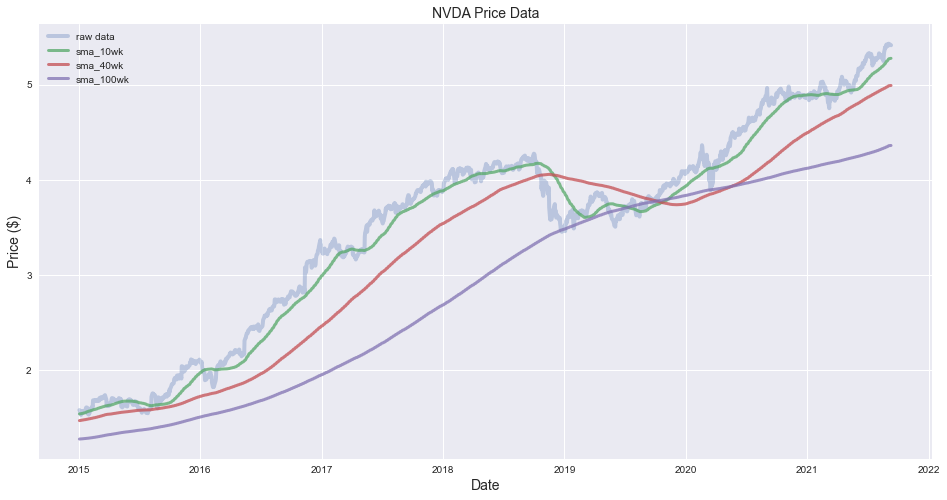

In [129]:
symb = "NVDA"
sma_distances = [10, 40, 100]
start_date = '2015-01-01'

symb_data = df.groupby("symbol").get_group(symb)
sma_cols = [np.log(symb_data["adj_close"]).rolling(dist * 7).mean() for dist in sma_distances]

for i in range(len(sma_cols)):
    col_len = len(symb_data.columns)
    col_name = f'sma_{sma_distances[i]}wk'
    col_data = sma_cols[i]
    symb_data.insert(col_len, col_name, col_data)

start_idx = np.where(symb_data.index >= start_date)[0][0]
sma_cols = symb_data.columns[["sma" in col for col in symb_data.columns]]

plt.figure(figsize=(16, 8))
plt.plot(np.log(symb_data["adj_close"].iloc[start_idx:]), linewidth=4, alpha=.3, label='raw data')

for col in sma_cols:
    plt.plot(symb_data[col].iloc[start_idx:], linewidth=3, alpha=.75, label=col)

plt.title(f"{symb} Price Data", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend()
plt.show()